In [42]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import time
import pandas as pd
from typing import List, Dict, Tuple, Optional, Any
from dataclasses import dataclass
import numpy.random as rnd

from alns import ALNS
from alns.accept import SimulatedAnnealing
from alns.select import RouletteWheel
from alns.stop import MaxIterations, MaxRuntime


In [43]:

# Set random seed for reproducibility
SEED = 2345
np.random.seed(SEED)

@dataclass
class PCTSPData:
    """Data class for a PCTSP instance"""
    instance_id: int
    size: int  # Number of nodes (not including depot)
    depot: np.ndarray  # Depot coordinates [x, y]
    locations: np.ndarray  # Node coordinates [n, 2]
    penalties: np.ndarray  # Penalties for skipping nodes
    prizes: np.ndarray  # Prizes for visiting nodes
    
    @property
    def total_prize(self):
        """The minimum required prize to collect"""
        return 1.0  # As per the problem definition (normalized)
    
    @classmethod
    def from_dict(cls, data_dict):
        """Create a PCTSPData object from a dictionary"""
        return cls(
            instance_id=data_dict['instance_id'],
            size=data_dict['size'],
            depot=data_dict['depot'],
            locations=data_dict['locations'],
            penalties=data_dict['penalties'],
            prizes=data_dict['deterministic_prize']
        )

class PCTSPSolution:
    """Represents a solution to the PCTSP problem"""
    def __init__(self, 
                 tour: List[int], 
                 unvisited: Optional[List[int]] = None):
        """
        Initialize a PCTSP solution
        
        Args:
            tour: List of node indices in the tour (does not include depot)
            unvisited: List of unvisited nodes (if None, will be determined based on the tour)
        """
        self.tour = tour
        if unvisited is None:
            self.unvisited = self._determine_unvisited()
        else:
            self.unvisited = unvisited

    def _determine_unvisited(self) -> List[int]:
        """Determine which nodes are unvisited based on the tour"""
        n = DATA.size
        unvisited = [i for i in range(n) if i not in self.tour]
        return unvisited
    
    def objective(self) -> float:
        """
        Calculate the objective value of the PCTSP solution
        
        Returns:
            Total cost = tour length + penalties for unvisited nodes
        """
        # Initialize tour with depot
        full_tour = [self.tour[i] for i in range(len(self.tour))]
        
        # Calculate tour length
        if not full_tour:
            # If no nodes are visited, the tour length is 0
            tour_length = 0
        else:
            # Distance from depot to first node
            tour_length = np.linalg.norm(DATA.depot - DATA.locations[full_tour[0]])
            
            # Distances between consecutive nodes
            for i in range(len(full_tour) - 1):
                tour_length += np.linalg.norm(
                    DATA.locations[full_tour[i]] - DATA.locations[full_tour[i+1]]
                )
            
            # Distance from last node back to depot
            tour_length += np.linalg.norm(DATA.locations[full_tour[-1]] - DATA.depot)
        
        # Calculate penalties for unvisited nodes
        penalty_cost = sum(DATA.penalties[i] for i in self.unvisited)
        
        return tour_length + penalty_cost
    
    def total_prize(self) -> float:
        """Calculate the total prize collected in the tour"""
        return sum(DATA.prizes[i] for i in self.tour)
    
    def is_feasible(self) -> bool:
        """Check if the solution satisfies the total prize constraint"""
        return self.total_prize() >= DATA.total_prize
    
    def insert(self, node: int, idx: int):
        """Insert a node at the specified index in the tour"""
        self.tour.insert(idx, node)
        if node in self.unvisited:
            self.unvisited.remove(node)
    
    def remove(self, node: int):
        """Remove a node from the tour"""
        self.tour.remove(node)
        self.unvisited.append(node)


In [44]:

def construct_initial_solution(use_greedy: bool = True) -> PCTSPSolution:
    """
    Construct an initial solution for the PCTSP
    
    Args:
        use_greedy: If True, use a greedy construction heuristic,
                    otherwise construct a random solution
    
    Returns:
        An initial PCTSP solution
    """
    n = DATA.size
    
    if use_greedy:
        # Calculate prize-to-penalty ratio for each node
        ratios = []
        for i in range(n):
            # Calculate distance from depot
            dist = np.linalg.norm(DATA.depot - DATA.locations[i])
            # Ratio of prize to (penalty + distance)
            ratio = DATA.prizes[i] / (DATA.penalties[i] + dist)
            ratios.append((i, ratio))
        
        # Sort nodes by decreasing ratio
        ratios.sort(key=lambda x: x[1], reverse=True)
        
        # Start with an empty tour
        tour = []
        current_prize = 0
        
        # Add nodes until prize constraint is satisfied
        for i, _ in ratios:
            tour.append(i)
            current_prize += DATA.prizes[i]
            if current_prize >= DATA.total_prize:
                break
        
        # Reorder tour using nearest neighbor
        if tour:
            reordered_tour = [tour[0]]
            remaining = tour[1:]
            
            while remaining:
                current = reordered_tour[-1]
                dists = []
                for i, node in enumerate(remaining):
                    dist = np.linalg.norm(DATA.locations[current] - DATA.locations[node])
                    dists.append((i, dist))
                
                closest_idx, _ = min(dists, key=lambda x: x[1])
                reordered_tour.append(remaining[closest_idx])
                del remaining[closest_idx]
            
            tour = reordered_tour
    else:
        # Randomly select nodes until prize constraint is satisfied
        available = list(range(n))
        np.random.shuffle(available)
        
        tour = []
        current_prize = 0
        
        for i in available:
            tour.append(i)
            current_prize += DATA.prizes[i]
            if current_prize >= DATA.total_prize:
                break
    
    # Create solution and ensure it's feasible
    solution = PCTSPSolution(tour)
    
    # If not feasible, add more nodes
    if not solution.is_feasible():
        available = solution.unvisited.copy()
        np.random.shuffle(available)
        
        while not solution.is_feasible() and available:
            node = available.pop(0)
            solution.insert(node, len(solution.tour))
    
    return solution


In [45]:

# ALNS Destroy Operators

def random_removal(solution: PCTSPSolution, rng, n_remove=5) -> PCTSPSolution:
    """
    Randomly remove n_remove nodes from the solution
    
    Args:
        solution: Current solution
        rng: Random number generator
        n_remove: Number of nodes to remove
    
    Returns:
        Destroyed solution
    """
    destroyed = deepcopy(solution)
    
    # Ensure the solution stays feasible after destruction
    remove_candidates = destroyed.tour.copy()
    
    # Calculate the "slack" in the prize collection
    prize_slack = destroyed.total_prize() - DATA.total_prize
    
    # Keep track of how much prize we can remove while staying feasible
    can_remove_prize = prize_slack
    
    # Shuffle candidates
    rng.shuffle(remove_candidates)
    
    # Remove nodes if feasible
    removed = 0
    for node in remove_candidates:
        if removed >= n_remove:
            break
            
        node_prize = DATA.prizes[node]
        if node_prize <= can_remove_prize or len(destroyed.tour) == 1:
            destroyed.remove(node)
            can_remove_prize -= node_prize
            removed += 1
    
    return destroyed

def worst_removal(solution: PCTSPSolution, rng, n_remove=5) -> PCTSPSolution:
    """
    Remove the n_remove nodes that contribute most to the objective
    
    Args:
        solution: Current solution
        rng: Random number generator
        n_remove: Number of nodes to remove
    
    Returns:
        Destroyed solution
    """
    destroyed = deepcopy(solution)
    
    # Calculate prize slack
    prize_slack = destroyed.total_prize() - DATA.total_prize
    
    # Calculate the contribution of each node to the objective
    contributions = []
    for idx, node in enumerate(destroyed.tour):
        # Create a tour without this node
        temp_tour = destroyed.tour[:idx] + destroyed.tour[idx+1:]
        temp_sol = PCTSPSolution(temp_tour)
        
        # Calculate the improvement in objective
        improvement = destroyed.objective() - temp_sol.objective()
        
        # Check if removal is feasible
        node_prize = DATA.prizes[node]
        is_feasible = (node_prize <= prize_slack) or (len(destroyed.tour) == 1)
        
        contributions.append((node, improvement, is_feasible))
    
    # Sort by contribution (highest first) then by feasibility
    contributions.sort(key=lambda x: (-x[1], not x[2]))
    
    # Remove nodes
    removed = 0
    for node, _, _ in contributions:
        if removed >= n_remove:
            break
            
        if node in destroyed.tour:
            node_prize = DATA.prizes[node]
            
            # Only remove if it keeps the solution feasible
            if node_prize <= prize_slack or len(destroyed.tour) == 1:
                destroyed.remove(node)
                prize_slack -= node_prize
                removed += 1
    
    return destroyed

def related_removal(solution: PCTSPSolution, rng, n_remove=5) -> PCTSPSolution:
    """
    Remove nodes that are close to each other
    
    Args:
        solution: Current solution
        rng: Random number generator
        n_remove: Number of nodes to remove
    
    Returns:
        Destroyed solution
    """
    destroyed = deepcopy(solution)
    
    # Calculate prize slack
    prize_slack = destroyed.total_prize() - DATA.total_prize
    
    if not destroyed.tour:
        return destroyed
    
    # Select a random seed node from the tour
    seed_idx = rng.integers(len(destroyed.tour))
    seed_node = destroyed.tour[seed_idx]
    seed_location = DATA.locations[seed_node]
    
    # Calculate distances from the seed node to all other nodes in the tour
    distances = []
    for idx, node in enumerate(destroyed.tour):
        dist = np.linalg.norm(seed_location - DATA.locations[node])
        distances.append((idx, node, dist))
    
    # Sort by distance (closest first)
    distances.sort(key=lambda x: x[2])
    
    # Remove nodes
    removed = 0
    for _, node, _ in distances:
        if removed >= n_remove:
            break
            
        if node in destroyed.tour:
            node_prize = DATA.prizes[node]
            
            # Only remove if it keeps the solution feasible
            if node_prize <= prize_slack or len(destroyed.tour) == 1:
                destroyed.remove(node)
                prize_slack -= node_prize
                removed += 1
    
    return destroyed

def path_removal(solution: PCTSPSolution, rng, n_remove=5) -> PCTSPSolution:
    """
    Remove a sequence of adjacent nodes in the tour
    
    Args:
        solution: Current solution
        rng: Random number generator
        n_remove: Number of nodes to remove
    
    Returns:
        Destroyed solution
    """
    destroyed = deepcopy(solution)
    
    # Calculate prize slack
    prize_slack = destroyed.total_prize() - DATA.total_prize
    
    if len(destroyed.tour) <= n_remove:
        # If removing all nodes would make solution infeasible, don't destroy
        return destroyed
    
    # Select a random starting position
    start_idx = rng.integers(len(destroyed.tour) - n_remove + 1)
    
    # Nodes to remove (as a contiguous path)
    nodes_to_remove = destroyed.tour[start_idx:start_idx + n_remove]
    
    # Calculate total prize of nodes to remove
    path_prize = sum(DATA.prizes[node] for node in nodes_to_remove)
    
    # Only remove if it keeps the solution feasible
    if path_prize <= prize_slack:
        # Remove nodes from the end to the beginning to maintain indices
        for i in range(n_remove - 1, -1, -1):
            destroyed.remove(destroyed.tour[start_idx + i])
    
    return destroyed


In [46]:

# ALNS Repair Operators

def greedy_repair(solution: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Repair the solution by greedily inserting nodes with the best cost-to-prize ratio
    
    Args:
        solution: Current solution
        rng: Random number generator
        
    Returns:
        Repaired solution
    """
    repaired = deepcopy(solution)
    
    # Check if the solution is already feasible
    if repaired.is_feasible():
        return repaired
    
    # Calculate how much prize we still need
    prize_needed = DATA.total_prize - repaired.total_prize()
    
    # Calculate the cost-benefit ratio for each unvisited node
    ratios = []
    for node in repaired.unvisited:
        # Simple insertion cost: distance from depot to node and back
        insertion_cost = (
            np.linalg.norm(DATA.depot - DATA.locations[node]) * 2
            - DATA.penalties[node]  # Subtract penalty savings
        )
        # Ratio of cost to prize
        ratio = insertion_cost / DATA.prizes[node] if DATA.prizes[node] > 0 else float('inf')
        ratios.append((node, ratio))
    
    # Sort by increasing ratio (best value first)
    ratios.sort(key=lambda x: x[1])
    
    # Insert nodes until the solution is feasible
    for node, _ in ratios:
        if repaired.is_feasible():
            break
            
        # Find the best insertion position
        best_pos = find_best_insertion_position(repaired, node)
        repaired.insert(node, best_pos)
    
    return repaired

def regret_repair(solution: PCTSPSolution, rng, n_regret=3, **kwargs) -> PCTSPSolution:
    """
    Repair the solution using regret-based insertion
    
    Args:
        solution: Current solution
        rng: Random number generator
        n_regret: Number of positions to consider for regret
        
    Returns:
        Repaired solution
    """
    repaired = deepcopy(solution)
    
    # Check if the solution is already feasible
    if repaired.is_feasible():
        return repaired
    
    while not repaired.is_feasible() and repaired.unvisited:
        # Calculate regret for each unvisited node
        regrets = []
        for node in repaired.unvisited:
            costs = []
            
            # Calculate cost for each insertion position
            for i in range(len(repaired.tour) + 1):
                # Create a temporary solution with the node inserted
                temp_sol = deepcopy(repaired)
                temp_sol.insert(node, i)
                costs.append((i, temp_sol.objective()))
            
            # Sort positions by increasing cost
            costs.sort(key=lambda x: x[1])
            
            # Calculate regret value
            regret_value = 0
            for j in range(1, min(n_regret, len(costs))):
                regret_value += costs[j][1] - costs[0][1]
            
            regrets.append((node, regret_value, costs[0][0]))  # (node, regret value, best position)
        
        # Select node with highest regret
        if not regrets:
            break
            
        regrets.sort(key=lambda x: (-x[1], x[2]))  # Sort by regret (highest first)
        node, _, pos = regrets[0]
        
        # Insert the selected node at its best position
        repaired.insert(node, pos)
    
    return repaired

def random_repair(solution: PCTSPSolution, rng, **kwargs) -> PCTSPSolution:
    """
    Repair the solution by randomly inserting nodes
    
    Args:
        solution: Current solution
        rng: Random number generator
        
    Returns:
        Repaired solution
    """
    repaired = deepcopy(solution)
    
    # Check if the solution is already feasible
    if repaired.is_feasible():
        return repaired
    
    # Create a list of unvisited nodes
    candidates = list(repaired.unvisited)
    rng.shuffle(candidates)
    
    # Insert nodes until the solution is feasible
    for node in candidates:
        if repaired.is_feasible():
            break
            
        # Find a random insertion position
        pos = rng.integers(len(repaired.tour) + 1)
        repaired.insert(node, pos)
    
    return repaired

def find_best_insertion_position(solution: PCTSPSolution, node: int) -> int:
    """
    Find the best position to insert a node in the tour
    
    Args:
        solution: Current solution
        node: Node to insert
        
    Returns:
        Best insertion position
    """
    best_pos = 0
    best_cost = float('inf')
    
    # Try all possible insertion positions
    for i in range(len(solution.tour) + 1):
        # Create a temporary solution with the node inserted
        temp_sol = deepcopy(solution)
        temp_sol.insert(node, i)
        cost = temp_sol.objective()
        
        # Update best position if better
        if cost < best_cost:
            best_cost = cost
            best_pos = i
    
    return best_pos


In [47]:

def plot_solution(solution: PCTSPSolution, title: str = "PCTSP Solution"):
    """
    Plot the PCTSP solution
    
    Args:
        solution: Solution to plot
        title: Plot title
    """
    plt.figure(figsize=(10, 10))
    
    # Plot all nodes
    plt.scatter(
        DATA.locations[:, 0], 
        DATA.locations[:, 1],
        c='lightgray', 
        s=50, 
        label='Unvisited nodes'
    )
    
    # Highlight visited nodes
    plt.scatter(
        [DATA.locations[i, 0] for i in solution.tour], 
        [DATA.locations[i, 1] for i in solution.tour],
        c='blue', 
        s=100, 
        label='Visited nodes'
    )
    
    # Mark the depot
    plt.scatter(
        DATA.depot[0], 
        DATA.depot[1],
        c='red', 
        s=200, 
        marker='*', 
        label='Depot'
    )
    
    # Add node indices for visited nodes
    for idx, node in enumerate(solution.tour):
        plt.annotate(
            str(node), 
            (DATA.locations[node, 0], DATA.locations[node, 1]),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    # Plot the tour
    if solution.tour:
        # Start from depot
        tour_x = [DATA.depot[0]]
        tour_y = [DATA.depot[1]]
        
        # Add each node in the tour
        for node in solution.tour:
            tour_x.append(DATA.locations[node, 0])
            tour_y.append(DATA.locations[node, 1])
        
        # Return to depot
        tour_x.append(DATA.depot[0])
        tour_y.append(DATA.depot[1])
        
        plt.plot(tour_x, tour_y, 'k-', alpha=0.7)
    
    plt.title(f"{title}\nCost: {solution.objective():.2f}, Nodes: {len(solution.tour)}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()


In [50]:
def run_alns(data_instance, n_iterations=1000, runtime=60):
    """
    Run the ALNS algorithm on a PCTSP instance
    """
    global DATA
    DATA = data_instance
    
    # Create initial solution
    initial_solution = construct_initial_solution(use_greedy=True)
    print(f"Initial solution cost: {initial_solution.objective():.2f}")
    
    # Initialize ALNS without random_state parameter
    alns = ALNS(rnd.default_rng(SEED)) # Initialize with default RNG
    
    # Add destroy operators
    alns.add_destroy_operator(random_removal)
    alns.add_destroy_operator(worst_removal)
    alns.add_destroy_operator(related_removal)
    alns.add_destroy_operator(path_removal)
    
    # Add repair operators
    alns.add_repair_operator(greedy_repair)
    alns.add_repair_operator(regret_repair)
    alns.add_repair_operator(random_repair)
    
    # Set acceptance criterion (simulated annealing)
    accept = SimulatedAnnealing(
        start_temperature=20.0,
        end_temperature=0.01,
        step=0.1,
        method="exponential"
    )
    
    # Set weight adjustment (roulette wheel)
    select = RouletteWheel(
        num_destroy=4,
        num_repair=3,
        scores=[1, 1, 1, 1, 1, 1, 1],  # Use scores instead of op_weights
        decay=0.8  # Use decay instead of op_decay
    )
    
    # Set stopping criterion
    stopping_criterion = MaxIterations(n_iterations)
    
    # Run the algorithm
    start_time = time.time()
    result = alns.iterate(
        initial_solution,
        select,
        accept,
        stopping_criterion
    )
    end_time = time.time()
    solution = result.best_state
    
    # Print results
    print(f"Best solution cost: {solution.objective():.2f}")
    print(f"Total prize collected: {solution.total_prize():.2f}")
    print(f"Number of nodes visited: {len(solution.tour)}")
    print(f"Time elapsed: {end_time - start_time:.2f} seconds")
    
    # Return solution and results
    stats = {
        'initial_cost': initial_solution.objective(),
        'final_cost': solution.objective(),
        'prize_collected': solution.total_prize(),
        'nodes_visited': len(solution.tour),
        'iterations': len(result.statistics.objectives),
        'time': end_time - start_time
    }
    
    return solution, stats

def solve_all_instances(problem_size=20):
    """
    Solve all PCTSP instances of a given size
    
    Args:
        problem_size: Size of problems to solve (20, 50, or 100)
    
    Returns:
        DataFrame with results
    """
    # Load instances
    filename = f"pctsp_data/pctsp_{problem_size}_20_instances.pkl"
    with open(filename, 'rb') as f:
        instances = pickle.load(f)
    
    results = []
    
    for instance_dict in instances:
        instance = PCTSPData.from_dict(instance_dict)
        print(f"\nSolving instance {instance.instance_id} of size {problem_size}...")
        
        # Run ALNS with longer runtime for larger instances
        runtime = 30 if problem_size <= 20 else (60 if problem_size <= 50 else 120)
        solution, stats = run_alns(instance, n_iterations=1000, runtime=runtime)
        
        # Record results
        results.append({
            'instance_id': instance.instance_id,
            'size': problem_size,
            'cost': stats['final_cost'],
            'nodes_visited': stats['nodes_visited'],
            'prize_collected': stats['prize_collected'],
            'initial_cost': stats['initial_cost'],
            'improvement': (stats['initial_cost'] - stats['final_cost']) / stats['initial_cost'] * 100,
            'iterations': stats['iterations'],
            'time': stats['time']
        })
        
        # Plot solution
        plot_solution(solution, f"PCTSP Solution - Instance {instance.instance_id} (Size {problem_size})")
    
    # Create DataFrame with results
    df = pd.DataFrame(results)
    print("\nSummary of results:")
    print(df.describe())
    
    return df

# Load a single instance for testing
def load_single_instance(problem_size=20, instance_id=1):
    """
    Load a single PCTSP instance
    
    Args:
        problem_size: Size of the problem (20, 50, or 100)
        instance_id: ID of the instance (1-20)
    
    Returns:
        PCTSPData object
    """
    filename = f"pctsp_data/pctsp_{problem_size}_20_instances.pkl"
    with open(filename, 'rb') as f:
        instances = pickle.load(f)
    
    # Find the instance with the given ID
    for instance_dict in instances:
        if instance_dict['instance_id'] == instance_id:
            return PCTSPData.from_dict(instance_dict)
    
    # If not found, return the first instance
    return PCTSPData.from_dict(instances[0])

def plot_instance(instance):
    """Plot the PCTSP instance"""
    plt.figure(figsize=(10, 10))
    
    # Plot all nodes
    plt.scatter(
        instance.locations[:, 0], 
        instance.locations[:, 1],
        c='blue', 
        s=50, 
        label='Nodes'
    )
    
    # Mark the depot
    plt.scatter(
        instance.depot[0], 
        instance.depot[1],
        c='red', 
        s=200, 
        marker='*', 
        label='Depot'
    )
    
    # Add node indices
    for i in range(instance.size):
        plt.annotate(
            str(i), 
            (instance.locations[i, 0], instance.locations[i, 1]),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    # Add prize and penalty information as text
    plt.figtext(0.5, 0.01, f"Node colors represent prize values", ha='center')
    
    plt.title(f"PCTSP Instance - {instance.size} nodes")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


Loaded instance with 20 nodes


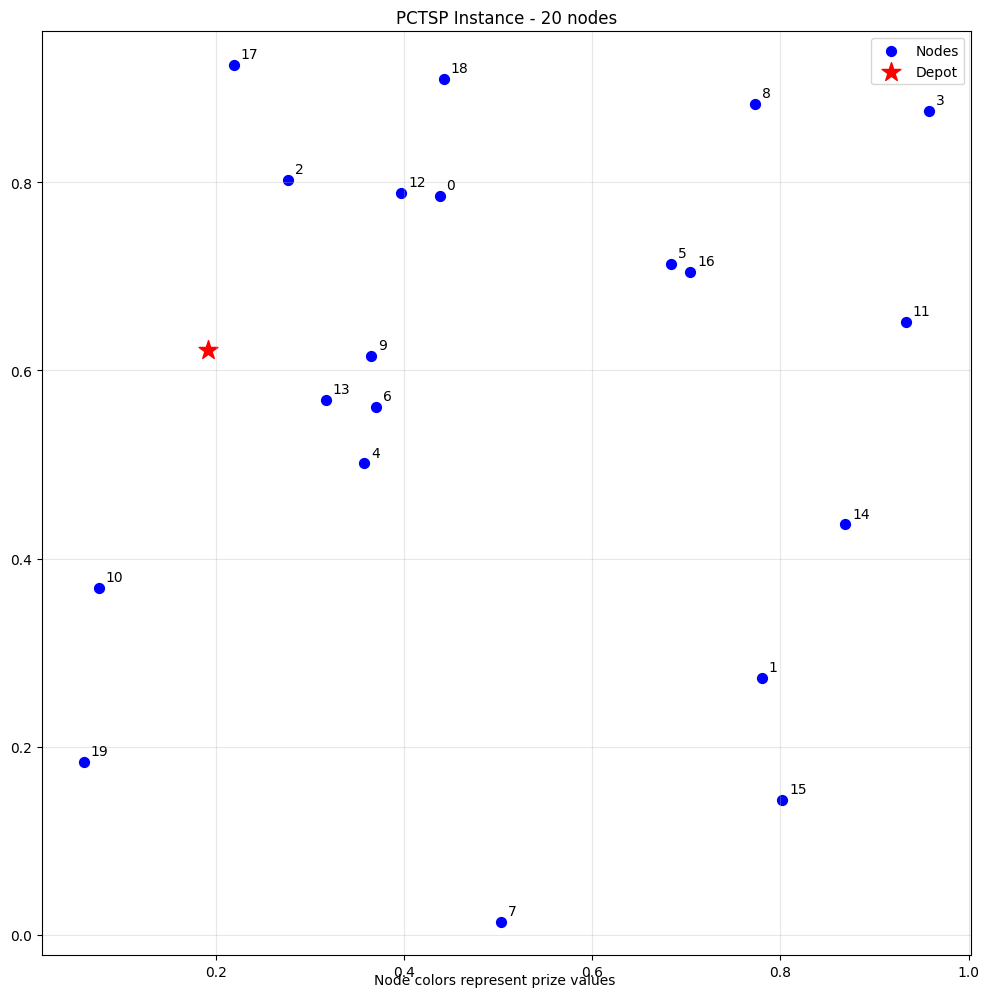

Initial solution cost: 4.84
Initial solution tour: [13, 9, 4, 0, 2, 5, 8, 10, 19]
Total prize collected: 1.12
Is feasible: True


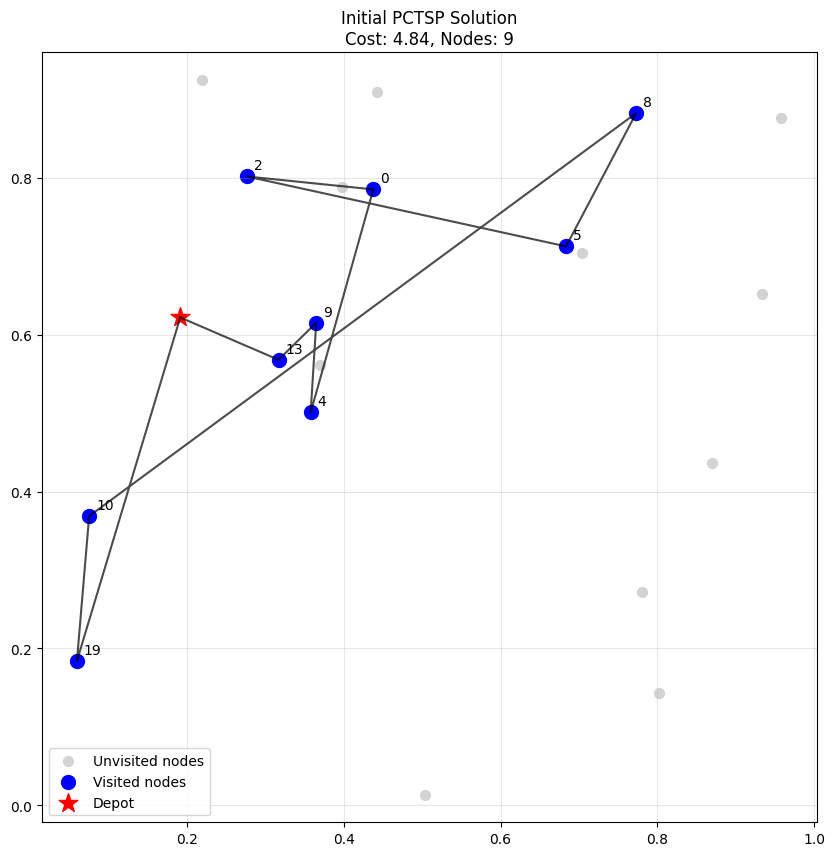

Initial solution cost: 4.84
Best solution cost: 4.69
Total prize collected: 1.04
Number of nodes visited: 8
Time elapsed: 0.06 seconds


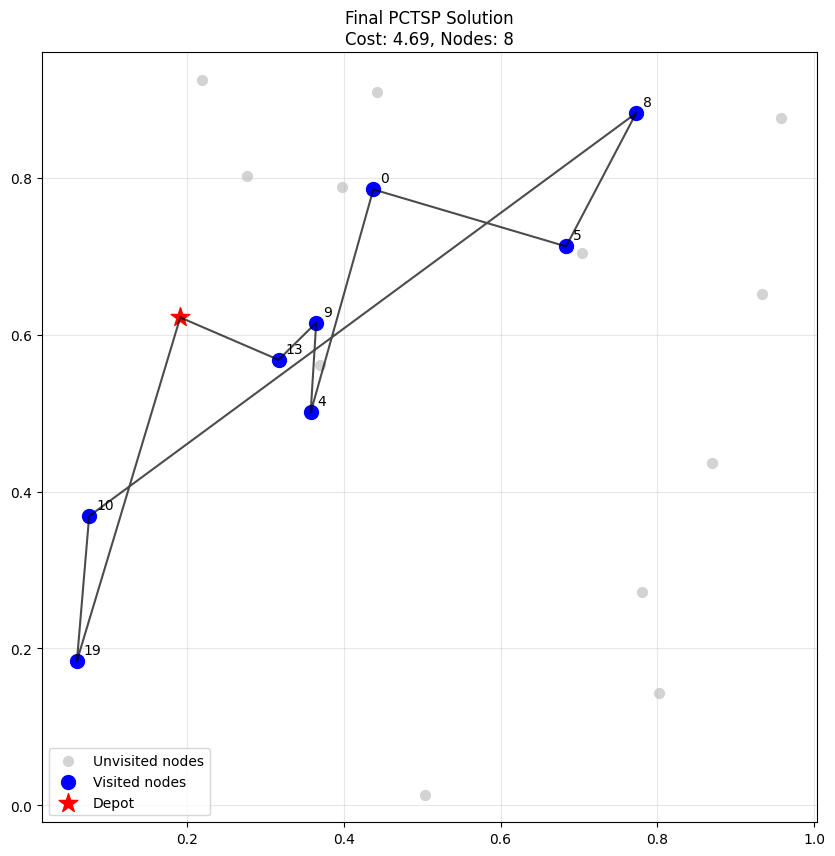


Solving instance 1 of size 20...
Initial solution cost: 4.84
Best solution cost: 4.69
Total prize collected: 1.04
Number of nodes visited: 8
Time elapsed: 0.21 seconds


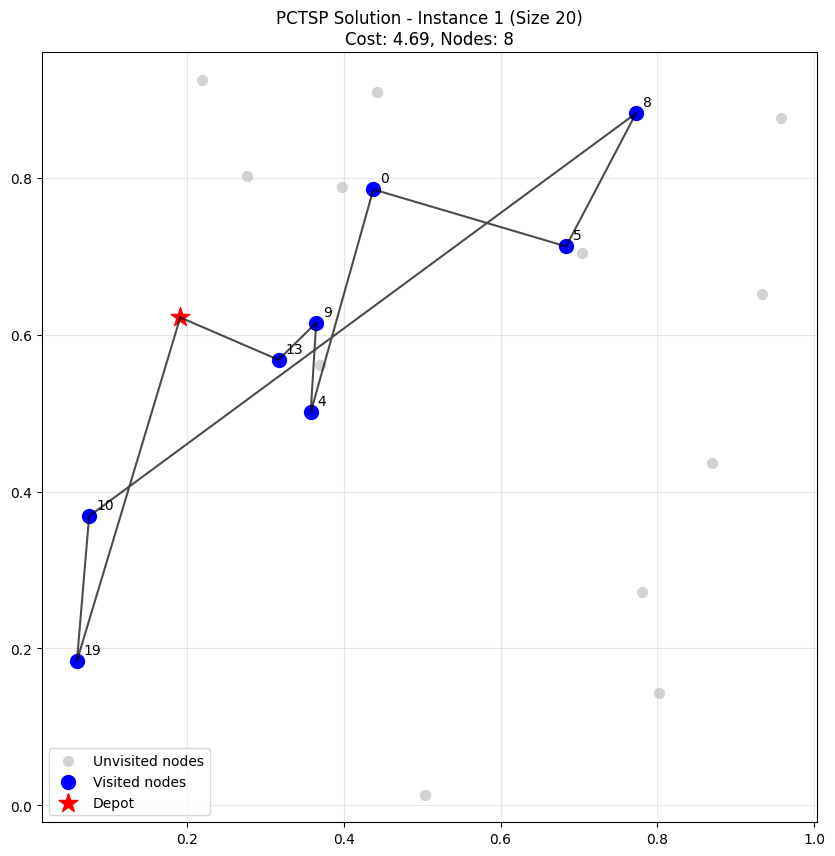


Solving instance 2 of size 20...
Initial solution cost: 4.77
Best solution cost: 4.77
Total prize collected: 1.04
Number of nodes visited: 6
Time elapsed: 0.19 seconds


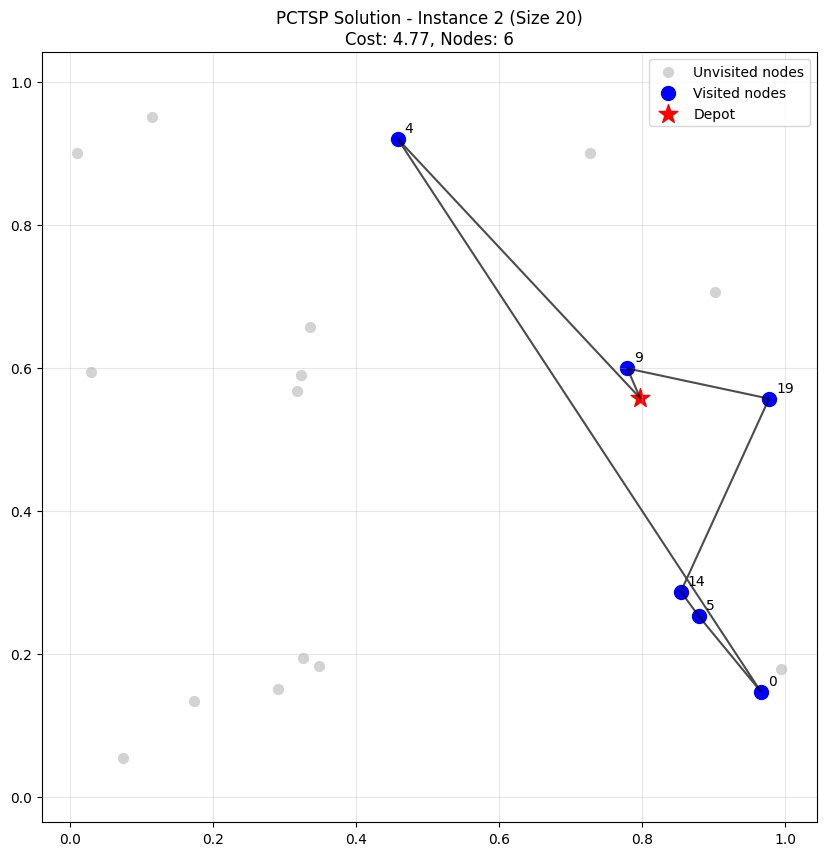


Solving instance 3 of size 20...
Initial solution cost: 5.69
Best solution cost: 5.60
Total prize collected: 1.00
Number of nodes visited: 7
Time elapsed: 0.24 seconds


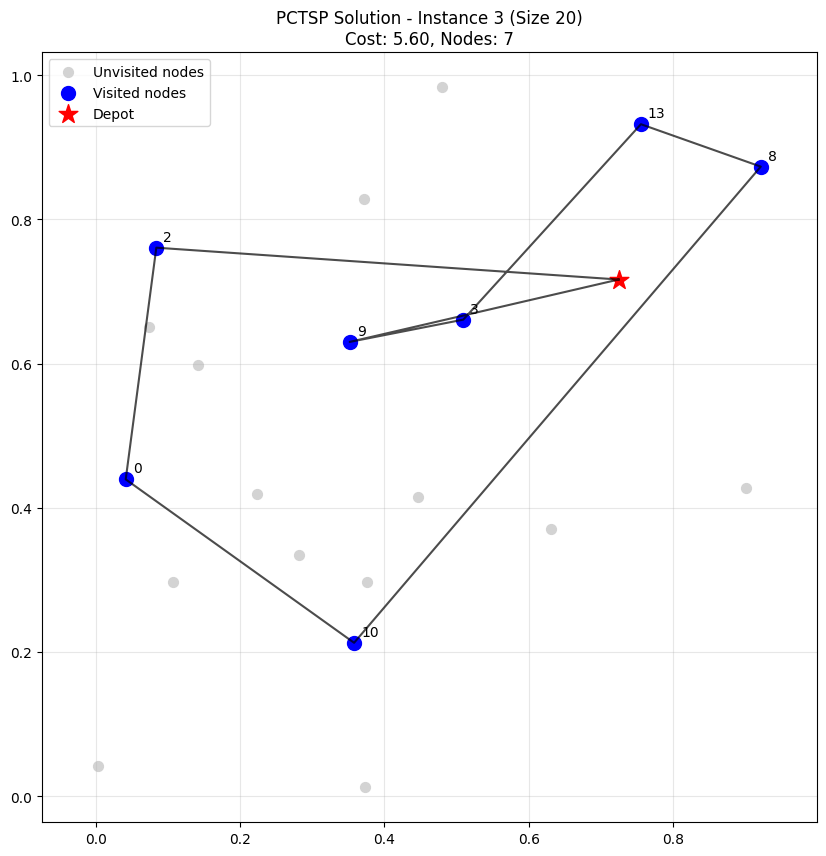


Solving instance 4 of size 20...
Initial solution cost: 4.61
Best solution cost: 4.61
Total prize collected: 1.13
Number of nodes visited: 9
Time elapsed: 0.25 seconds


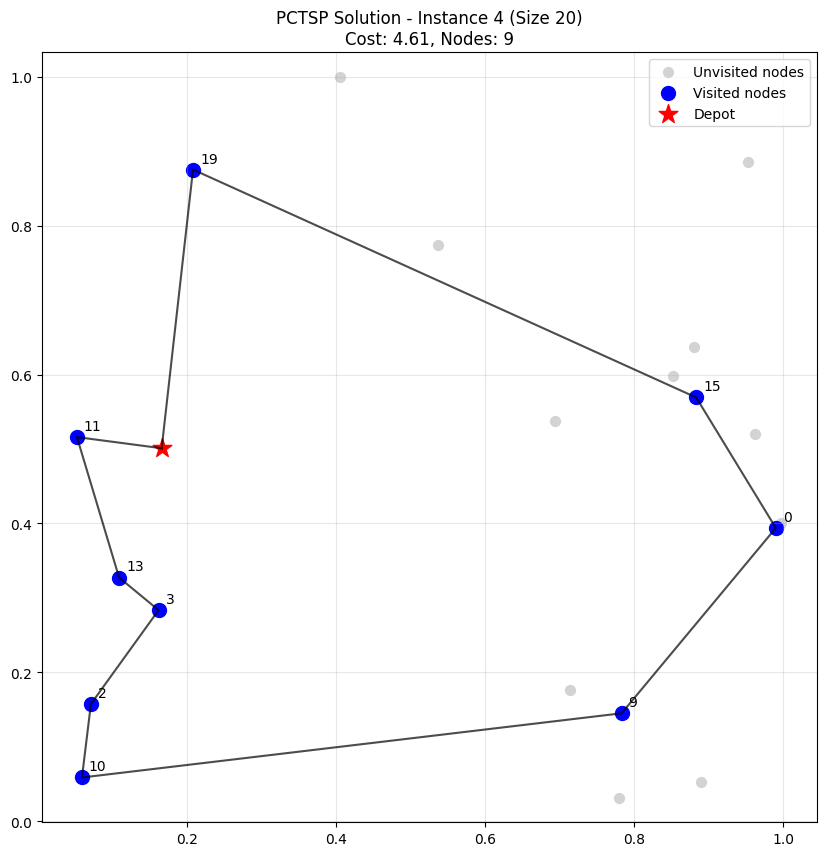


Solving instance 5 of size 20...
Initial solution cost: 3.98
Best solution cost: 3.98
Total prize collected: 1.02
Number of nodes visited: 7
Time elapsed: 0.24 seconds


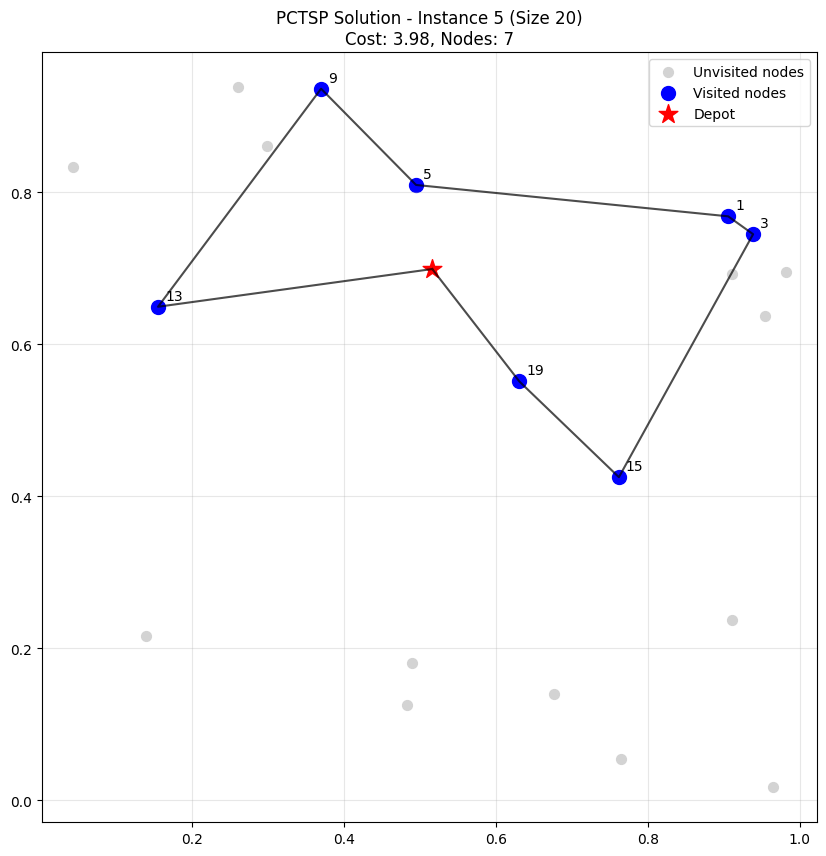


Solving instance 6 of size 20...
Initial solution cost: 4.34
Best solution cost: 4.34
Total prize collected: 1.16
Number of nodes visited: 7
Time elapsed: 0.22 seconds


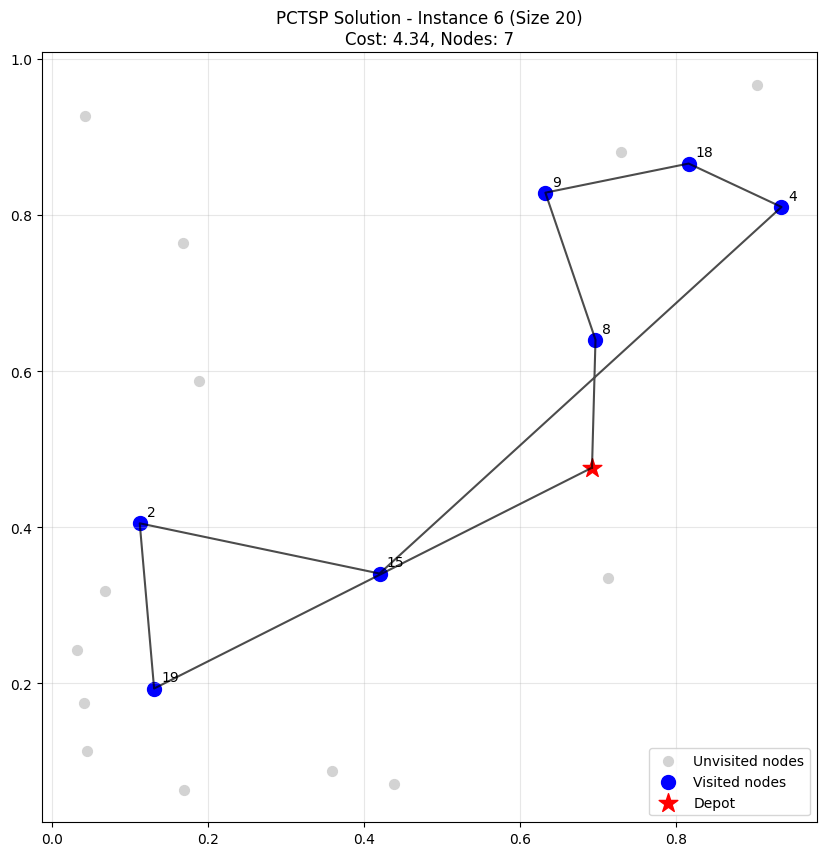


Solving instance 7 of size 20...
Initial solution cost: 5.17
Best solution cost: 5.17
Total prize collected: 1.03
Number of nodes visited: 8
Time elapsed: 0.25 seconds


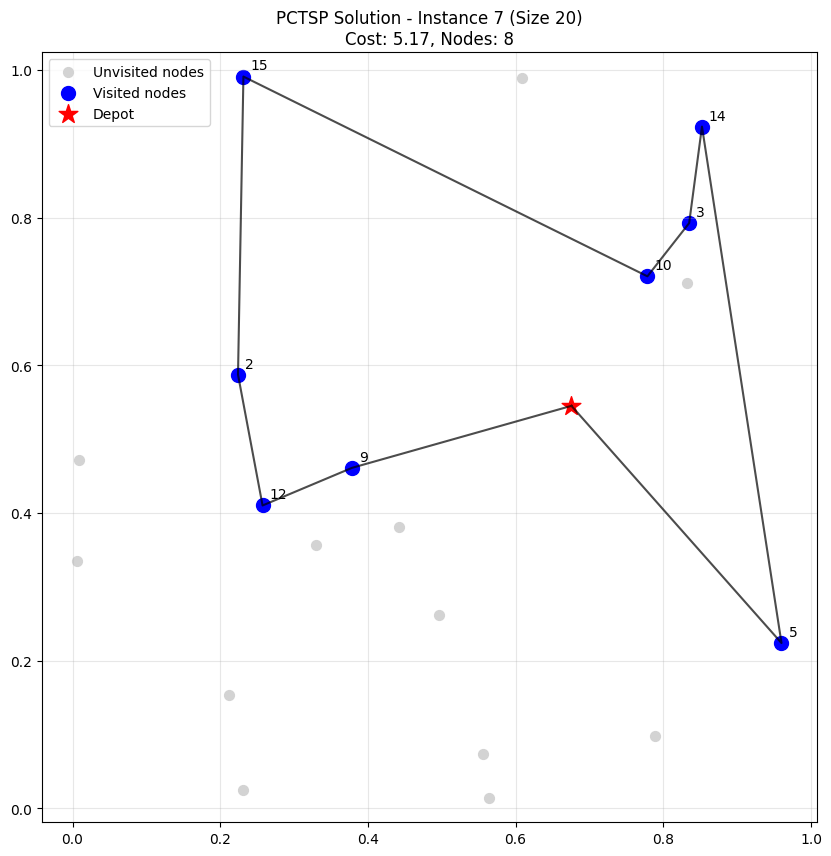


Solving instance 8 of size 20...
Initial solution cost: 5.41
Best solution cost: 5.41
Total prize collected: 1.08
Number of nodes visited: 7
Time elapsed: 0.20 seconds


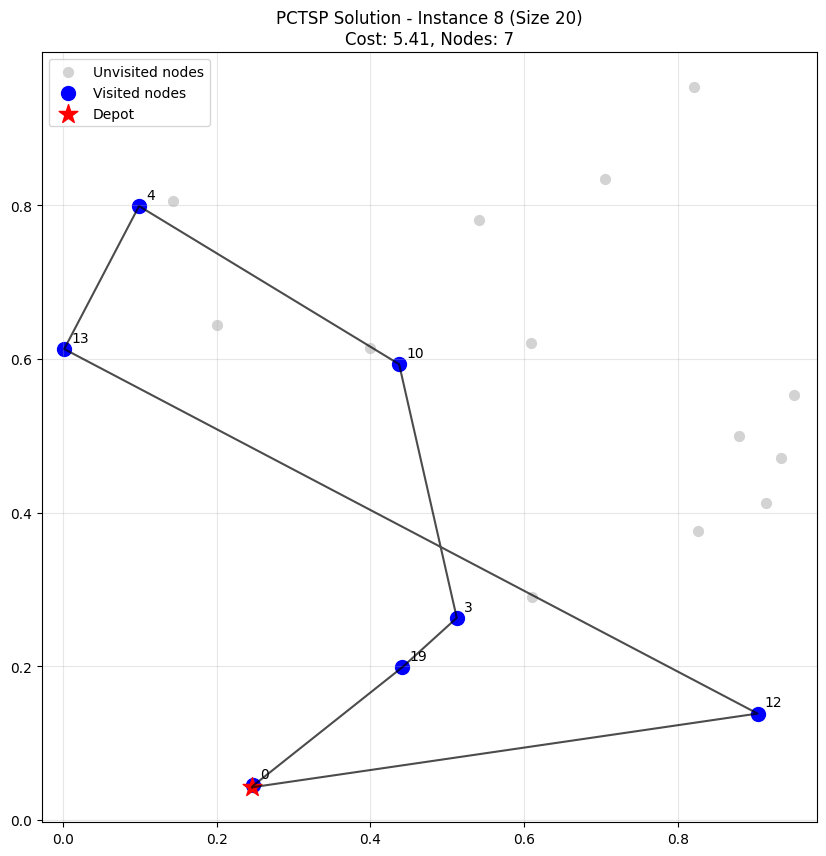


Solving instance 9 of size 20...
Initial solution cost: 4.90
Best solution cost: 4.90
Total prize collected: 1.09
Number of nodes visited: 7
Time elapsed: 0.24 seconds


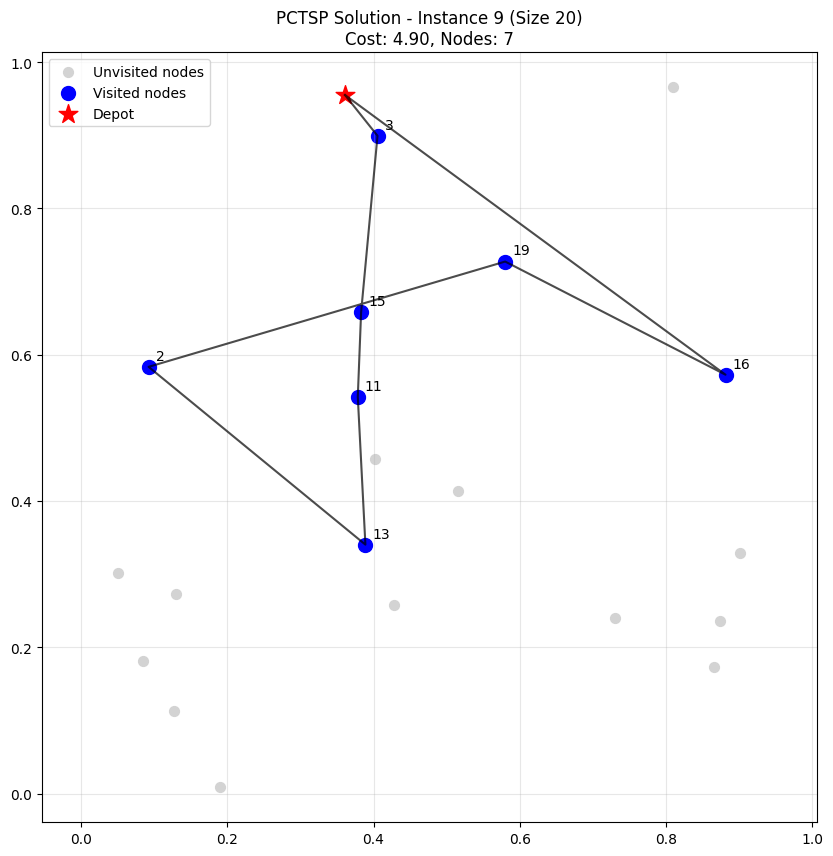


Solving instance 10 of size 20...
Initial solution cost: 5.91
Best solution cost: 5.91
Total prize collected: 1.03
Number of nodes visited: 6
Time elapsed: 0.24 seconds


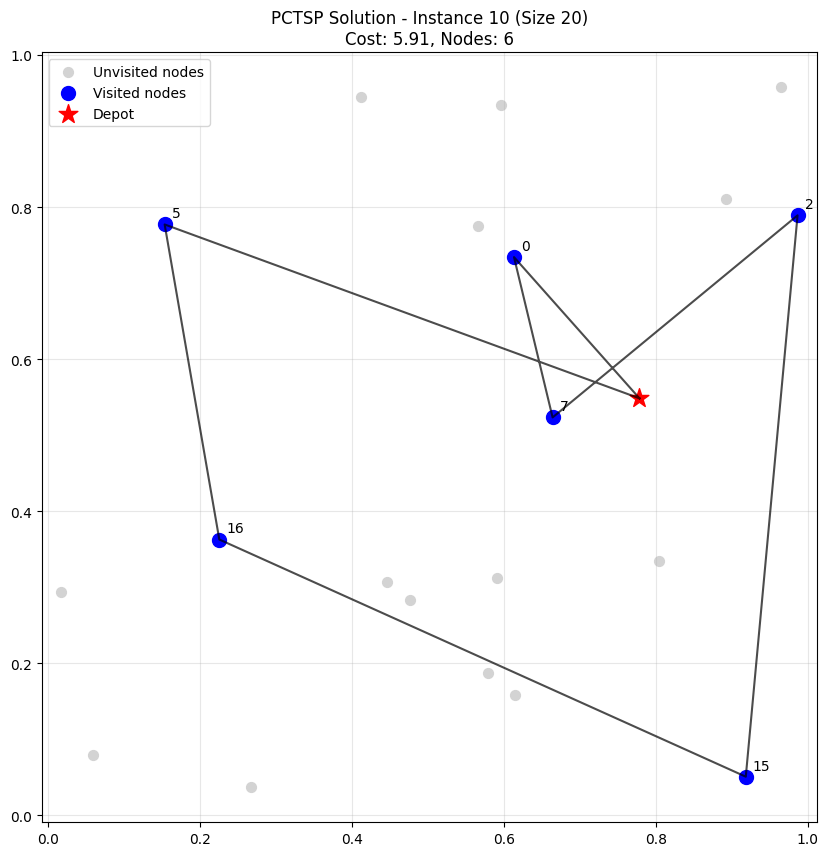


Solving instance 11 of size 20...
Initial solution cost: 4.19
Best solution cost: 4.19
Total prize collected: 1.00
Number of nodes visited: 7
Time elapsed: 0.29 seconds


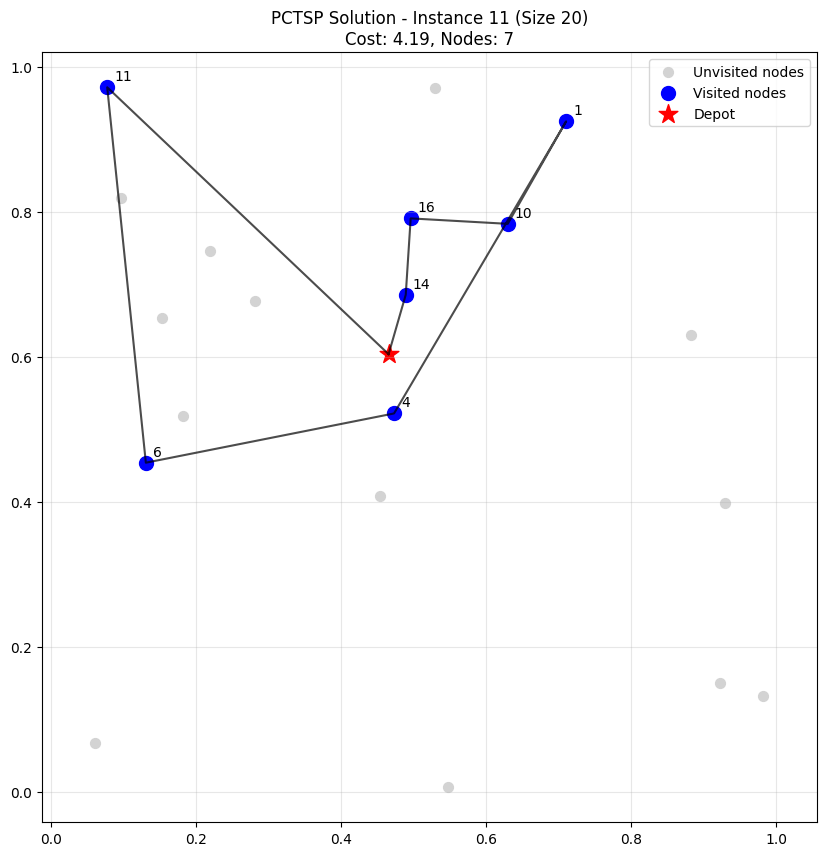


Solving instance 12 of size 20...
Initial solution cost: 4.82
Best solution cost: 4.82
Total prize collected: 1.01
Number of nodes visited: 7
Time elapsed: 0.23 seconds


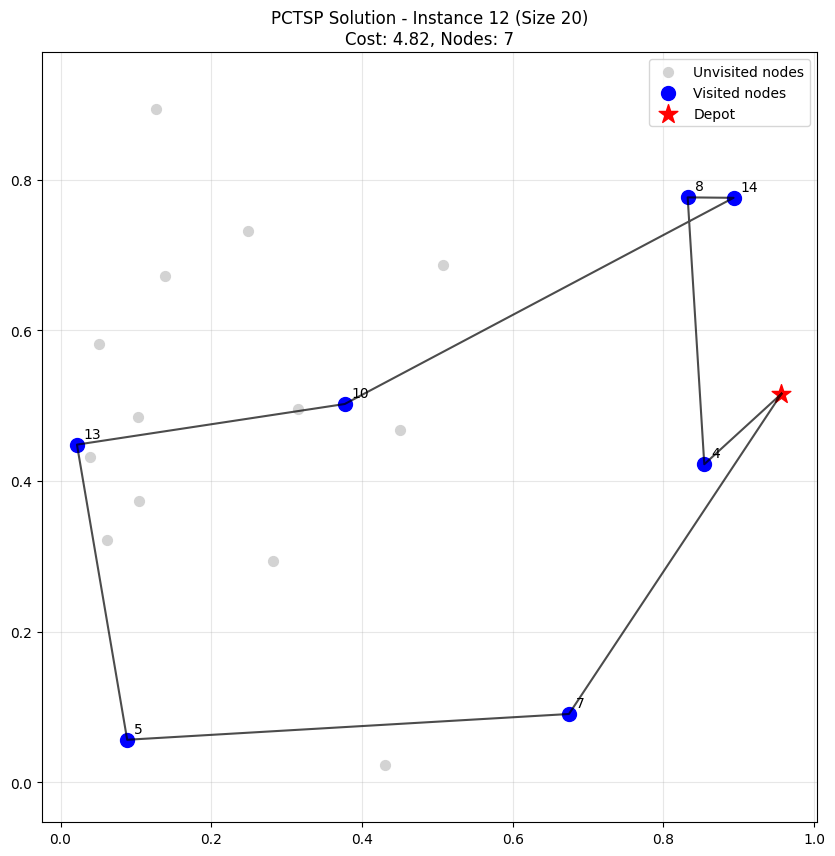


Solving instance 13 of size 20...
Initial solution cost: 4.40
Best solution cost: 4.40
Total prize collected: 1.15
Number of nodes visited: 7
Time elapsed: 0.19 seconds


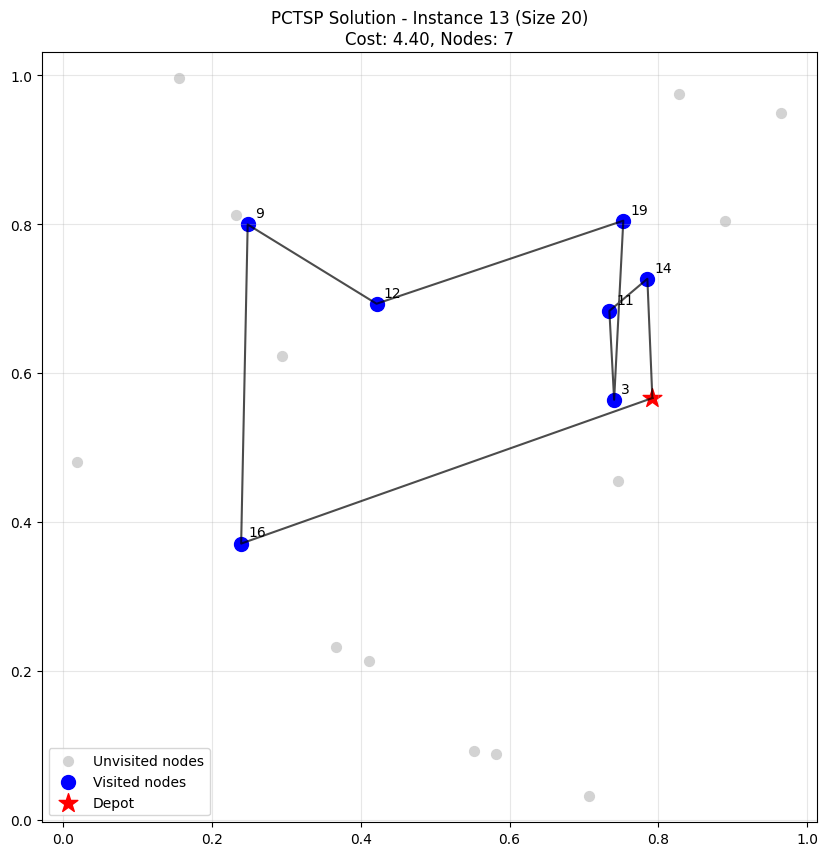


Solving instance 14 of size 20...
Initial solution cost: 5.09
Best solution cost: 5.09
Total prize collected: 1.06
Number of nodes visited: 8
Time elapsed: 0.29 seconds


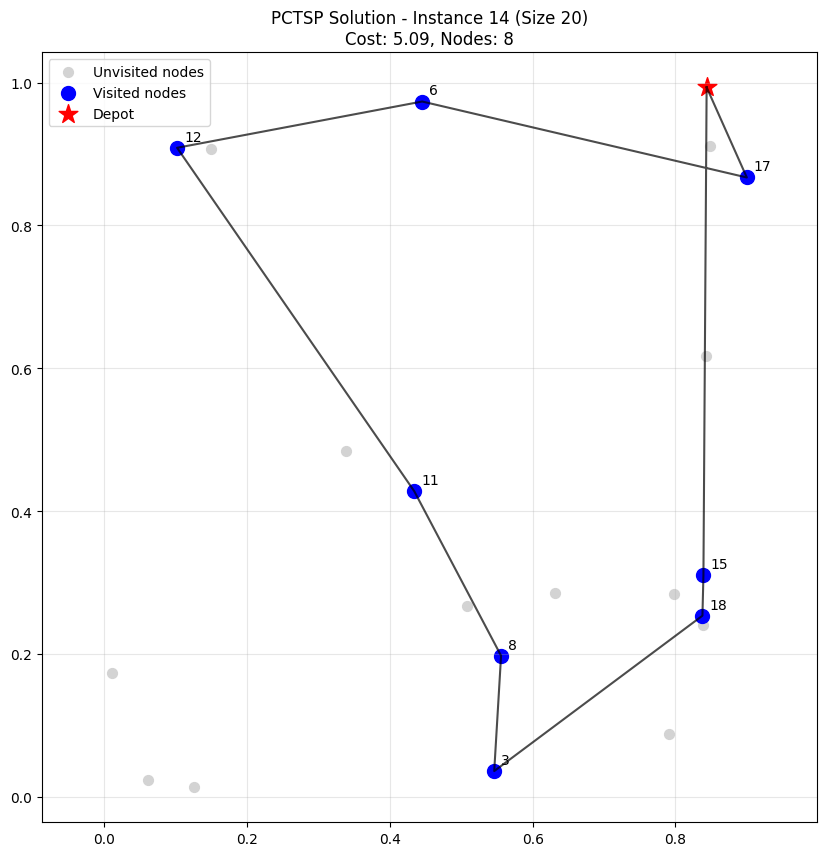


Solving instance 15 of size 20...
Initial solution cost: 5.20
Best solution cost: 5.20
Total prize collected: 1.00
Number of nodes visited: 7
Time elapsed: 0.22 seconds


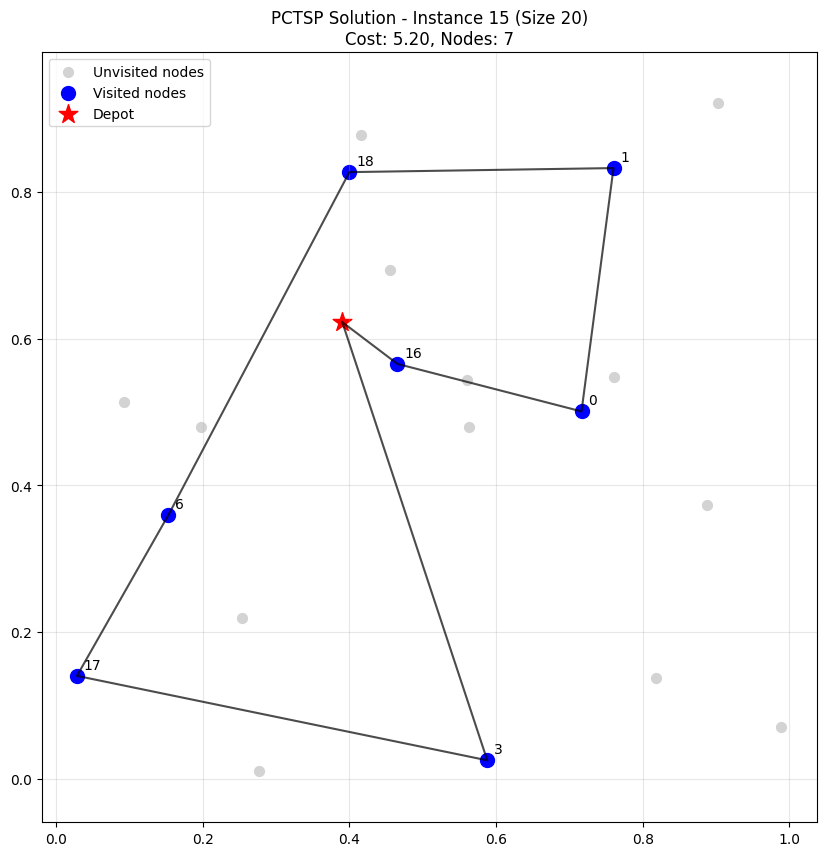


Solving instance 16 of size 20...
Initial solution cost: 4.80
Best solution cost: 4.80
Total prize collected: 1.11
Number of nodes visited: 7
Time elapsed: 0.27 seconds


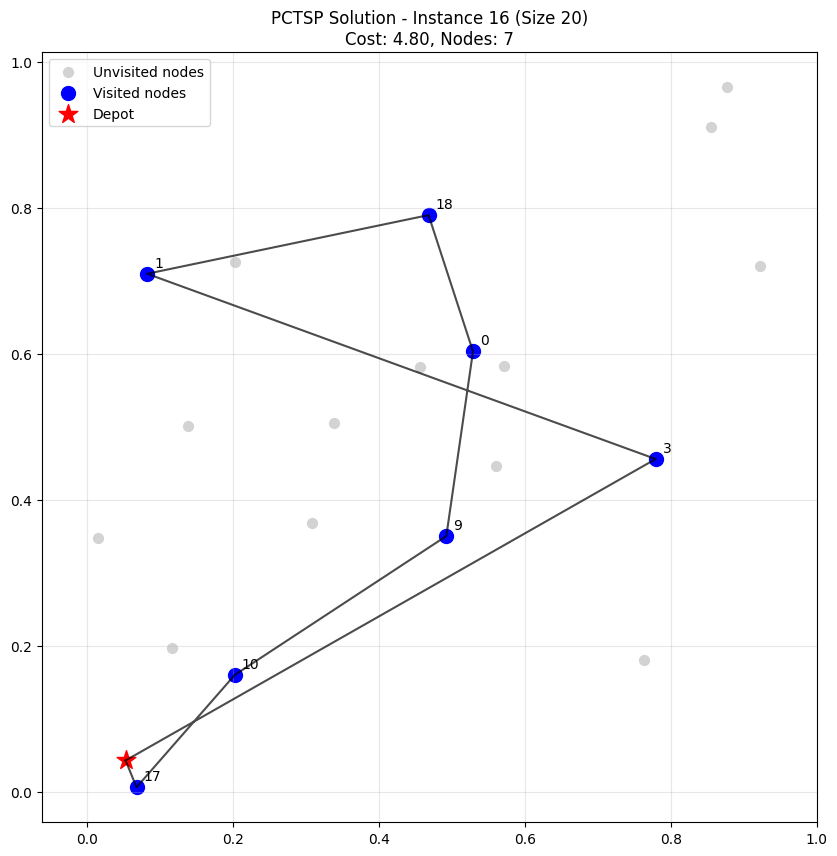


Solving instance 17 of size 20...
Initial solution cost: 5.45
Best solution cost: 5.45
Total prize collected: 1.11
Number of nodes visited: 9
Time elapsed: 0.24 seconds


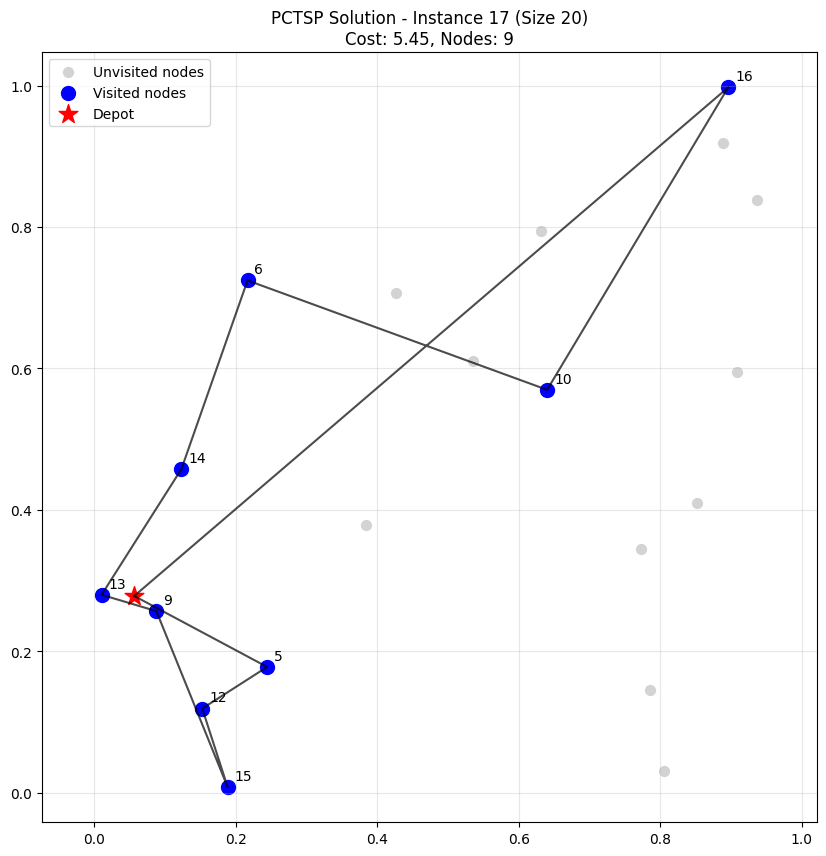


Solving instance 18 of size 20...
Initial solution cost: 4.52
Best solution cost: 4.45
Total prize collected: 1.03
Number of nodes visited: 7
Time elapsed: 0.21 seconds


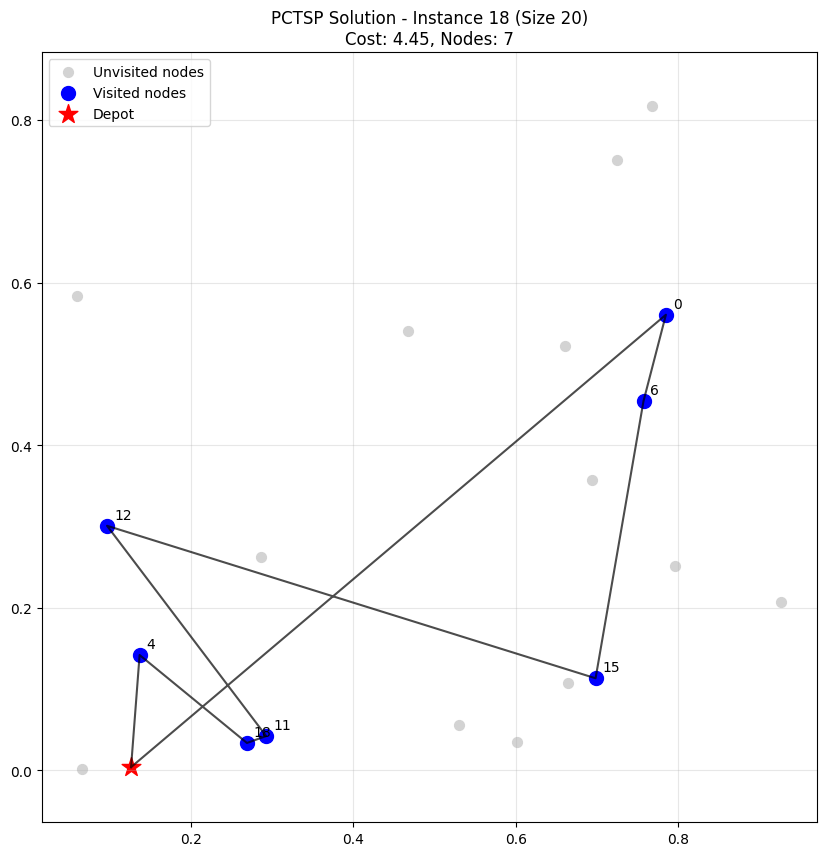


Solving instance 19 of size 20...
Initial solution cost: 5.11
Best solution cost: 5.11
Total prize collected: 1.03
Number of nodes visited: 7
Time elapsed: 0.24 seconds


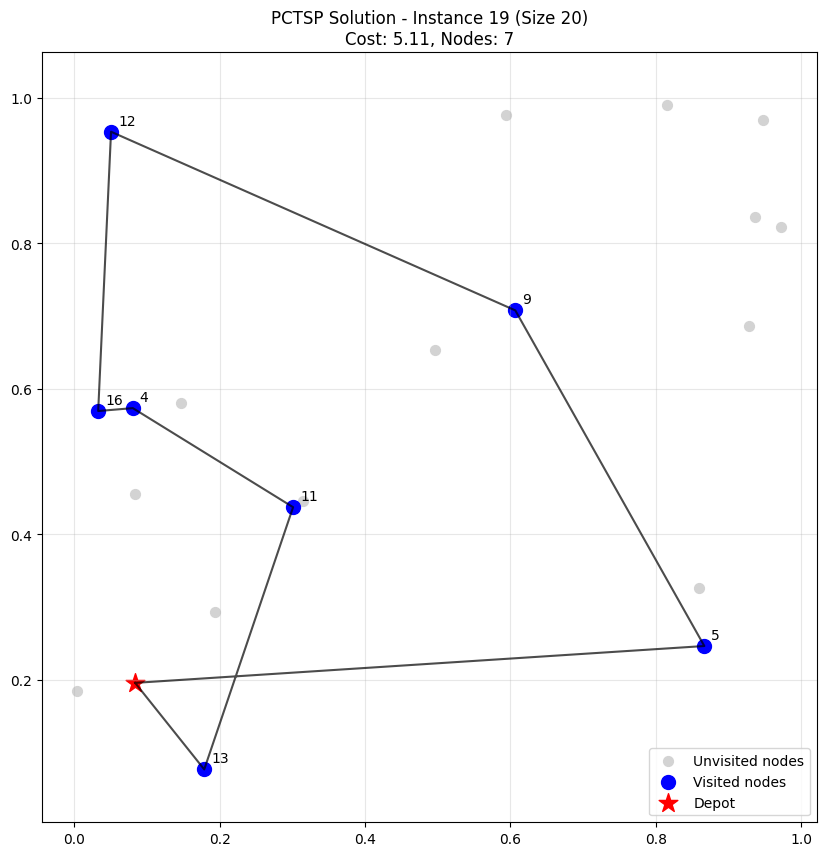


Solving instance 20 of size 20...
Initial solution cost: 5.54
Best solution cost: 5.54
Total prize collected: 1.07
Number of nodes visited: 7
Time elapsed: 0.27 seconds


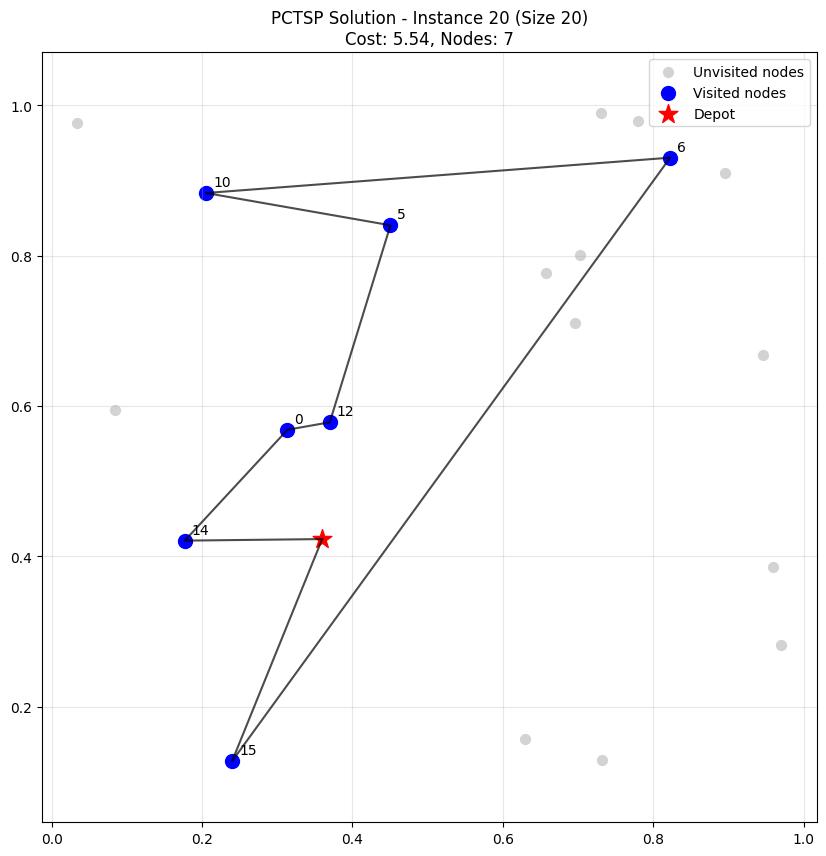


Summary of results:
       instance_id  size       cost  nodes_visited  prize_collected  \
count     20.00000  20.0  20.000000      20.000000        20.000000   
mean      10.50000  20.0   4.920963       7.250000         1.060588   
std        5.91608   0.0   0.513083       0.786398         0.050672   
min        1.00000  20.0   3.975990       6.000000         1.000524   
25%        5.75000  20.0   4.569871       7.000000         1.024998   
50%       10.50000  20.0   4.858150       7.000000         1.044497   
75%       15.25000  20.0   5.253035       7.250000         1.096086   
max       20.00000  20.0   5.913882       9.000000         1.163793   

       initial_cost  improvement  iterations       time  
count     20.000000    20.000000        20.0  20.000000  
mean       4.936237     0.306942      1001.0   0.237145  
std        0.514042     0.794107         0.0   0.028925  
min        3.975990     0.000000      1001.0   0.187604  
25%        4.587733     0.000000      1001.0   0.

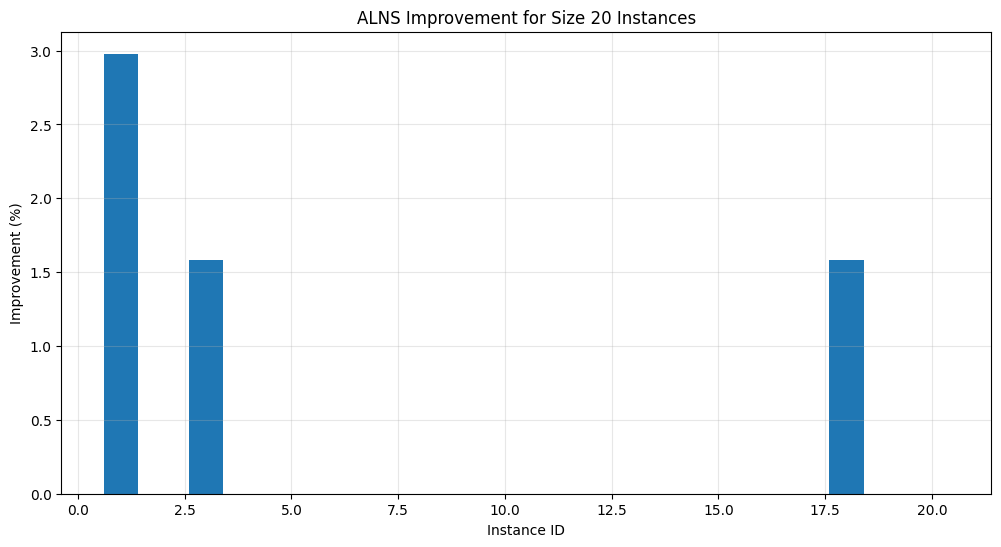

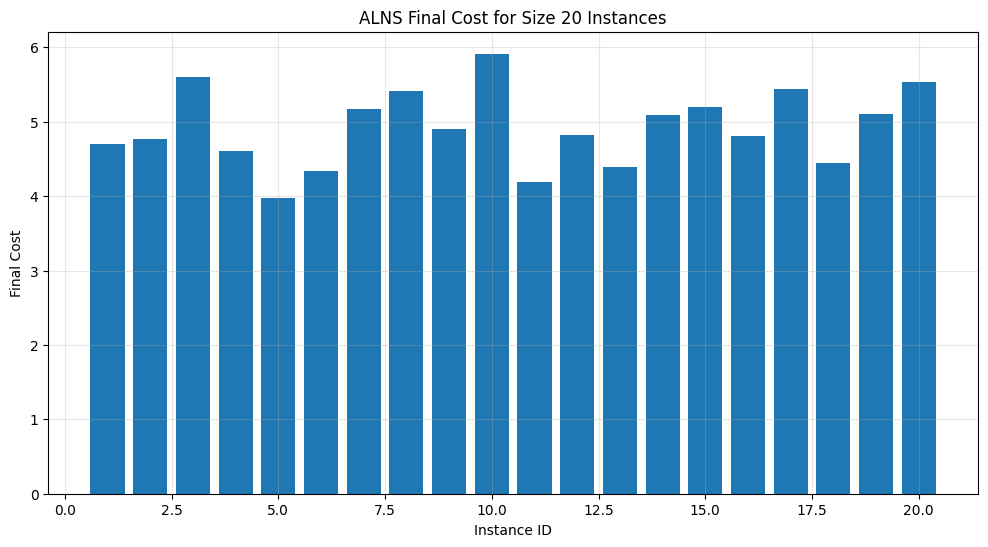

In [51]:

# Main execution part
if __name__ == "__main__":
    # Load an instance
    instance = load_single_instance(problem_size=20, instance_id=1)
    print(f"Loaded instance with {instance.size} nodes")
    
    # Visualize the instance
    plot_instance(instance)
    
    # Set the global DATA variable
    DATA = instance
    
    # Create an initial solution
    initial_solution = construct_initial_solution(use_greedy=True)
    print(f"Initial solution cost: {initial_solution.objective():.2f}")
    print(f"Initial solution tour: {initial_solution.tour}")
    print(f"Total prize collected: {initial_solution.total_prize():.2f}")
    print(f"Is feasible: {initial_solution.is_feasible()}")
    
    # Visualize the initial solution
    plot_solution(initial_solution, "Initial PCTSP Solution")
    
    # Run ALNS on the instance
    solution, stats = run_alns(instance, n_iterations=100, runtime=30)
    
    # Visualize the final solution
    plot_solution(solution, "Final PCTSP Solution")
    
    # Solve all instances of a given size
    df_20 = solve_all_instances(20)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.bar(df_20['instance_id'], df_20['improvement'])
    plt.xlabel('Instance ID')
    plt.ylabel('Improvement (%)')
    plt.title('ALNS Improvement for Size 20 Instances')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot cost distribution
    plt.figure(figsize=(12, 6))
    plt.bar(df_20['instance_id'], df_20['cost'])
    plt.xlabel('Instance ID')
    plt.ylabel('Final Cost')
    plt.title('ALNS Final Cost for Size 20 Instances')
    plt.grid(True, alpha=0.3)
    plt.show()